# Loop Hydrodynamics: Low-frequency heating

In [1]:
import os
import collections
import sys
import subprocess
import multiprocessing

import numpy as np
from scipy.optimize import curve_fit,brentq
import astropy.units as u
from astropy.utils.console import ProgressBar
import matplotlib.pyplot as plt

import synthesizAR
from synthesizAR.interfaces.ebtel import EbtelInterface

sys.path.append('../../scripts/')
from constrained_heating_model import CustomHeatingModel

%matplotlib inline

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
field = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/base_noaa1158/')

In [3]:
heating_options = {
    'duration': 200.0,
    'duration_rise': 100.0,
    'duration_decay': 100.0,
    'stress_level': 1.,
    'power_law_slope': -2.5,
    'frequency_parameter': 5.,
}

In [4]:
heating_model = CustomHeatingModel(heating_options)

In [8]:
field.loops[1].coordinates

<SkyCoord (HeliographicStonyhurst: obstime=None): (x, y, z) in cm
    [( 6.06464154e+10,  6.08223280e+10,  6.09809224e+10),
     (-2.44340937e+10, -2.43505521e+10, -2.42343036e+10),
     (-2.46270738e+10, -2.45538111e+10, -2.44861632e+10)]>

In [5]:
ih = synthesizAR.util.InputHandler('/storage-home/w/wtb2/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 3e4
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1e-6
base_config['force_single_fluid'] = False
base_config['tau_max'] = 200.0

In [6]:
ebtel_interface = EbtelInterface(base_config,heating_model,
                                 '/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/hydro_config/',
                                 '/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/hydro_results/')

In [7]:
heating_model.constrain_distribution(field,
                                     tolerance=1e-3,
                                     ar_flux_constraint=1e7,
                                     sigma_increase=1.,sigma_decrease=1e-6,
                                     verbose=True)

Iteration 0 with error=0.672606214140357 and phi=0.3273937858596429
Iteration 1 with error=0.4730752844610552 and phi=0.5269247155389448
Iteration 2 with error=0.24185513579277895 and phi=0.758144864207221
Iteration 3 with error=0.08118546097040324 and phi=0.9188145390295968
Iteration 4 with error=0.02032507245495696 and phi=0.979674927545043
Iteration 5 with error=0.00131676730504382 and phi=1.0013167673050438
Iteration 6 with error=0.014351697651466155 and phi=0.9856483023485338
Iteration 7 with error=0.0027105986106723545 and phi=1.0027105986106724
Iteration 8 with error=0.00436886318087748 and phi=0.9956311368191225
Iteration 9 with error=0.0036956419140743435 and phi=1.0036956419140743
Iteration 10 with error=0.01823618658590065 and phi=1.0182361865859006
Iteration 11 with error=0.011937531755378261 and phi=0.9880624682446217
Iteration 12 with error=0.017430652793598345 and phi=0.9825693472064017
Iteration 13 with error=0.00918475420168896 and phi=1.009184754201689
Iteration 14 wi

Check that we are obeying the constraint and take a look at the distribution of $\epsilon$ values, i.e. for each event, what fraction of the energy is being extracted from the field. This value should be close to 1 as the average flux over time and over all strands should be $\approx 10^7$ erg cm$^{-2}$ s$^{-1}$, the constraint from WN77 

In [64]:
tot = 0.
energies = []
loop_energies = []
for l in field.loops:
    energies += (heating_model.power_law_distributions[l.name] / ((l.field_strength.value.mean()**2)/8./np.pi)).tolist()
    loop_energies.append((heating_model.power_law_distributions[l.name] / ((l.field_strength.value.mean()**2)/8./np.pi)))
    tot += heating_model.power_law_distributions[l.name].sum()*l.full_length.to(u.cm).value
print(tot / len(field.loops) / base_config['total_time'] / 1e7)

1.00042786689


In [65]:
def mle(x,xmin,xmax,alpha_bounds=[1.1,10]):
    #define mle function
    def f_mle(alpha,xi,x_min,x_max):
        n = len(xi)
        term1 = -np.sum(np.log(xi))
        term2 = n/(alpha - 1.0)
        term3a = n/(x_min**(1.0-alpha) - x_max**(1.0-alpha))
        term3b = x_min**(1.0-alpha)*np.log(x_min) - x_max**(1.0-alpha)*np.log(x_max)
        return term1 + term2 + term3a*term3b
    
    x0,r = brentq(f_mle,alpha_bounds[0],alpha_bounds[1],args=(x,xmin,xmax),full_output=True)
    if r.converged:
        return x0
    else:
        print('Minimization not sucessful. Returning None')
        return None

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in double_scalars
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars


(1, 50000.0)

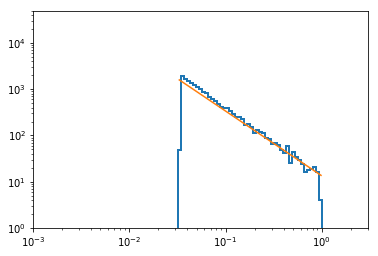

In [66]:
hist,bins,_ = plt.hist(np.array(energies),
                       bins=np.logspace(-3,0.1,100),
                       lw=2,histtype='step',density=False,);
def fit_func(x,a,b):
    return a*x + b
power_law_slopes = np.zeros((len(field.loops),))
for i,le in enumerate(loop_energies):
    try:
        power_law_slopes[i] = mle(le,le.min(),le.max(),)
    except (RuntimeError,ValueError):
        power_law_slopes[i] = np.nan
bin_centers = (bins[1:] + bins[:-1])/2.
bin_centers = bin_centers[hist>0]
popt,pcov = curve_fit(fit_func, np.log10(bin_centers), np.log10(hist[hist>0]),)
plt.plot(bin_centers,(10.**popt[1])*(bin_centers**popt[0]),color='C1')
#plt.axvline(x=0.3,ls=':',color='k')
#plt.axvline(x=0.1,ls=':',color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-3,3)
plt.ylim(1,5e4)
#plt.title(r'$\alpha$={:.3f}'.format(popt[0]));

(0, 3)

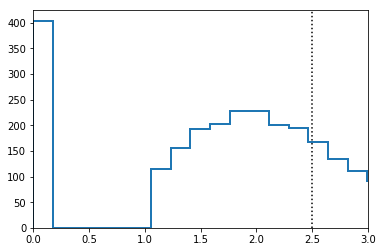

In [68]:
plt.hist(power_law_slopes[~np.isnan(power_law_slopes)],bins='fd',histtype='step',lw=2);
plt.axvline(x=2.5,ls=':',color='K')
plt.xlim(0,3)

In [12]:
field.configure_loop_simulations(ebtel_interface)

FloatProgress(value=0.0)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


In [13]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/storage-home/w/wtb2/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [14]:
pool = multiprocessing.Pool()

In [15]:
runs = pool.map_async(ebtel_runner,field.loops)
runs.wait()

In [16]:
field.load_loop_simulations(ebtel_interface,
                            savefile='/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/loop_parameters.h5'
                           )

FloatProgress(value=0.0)

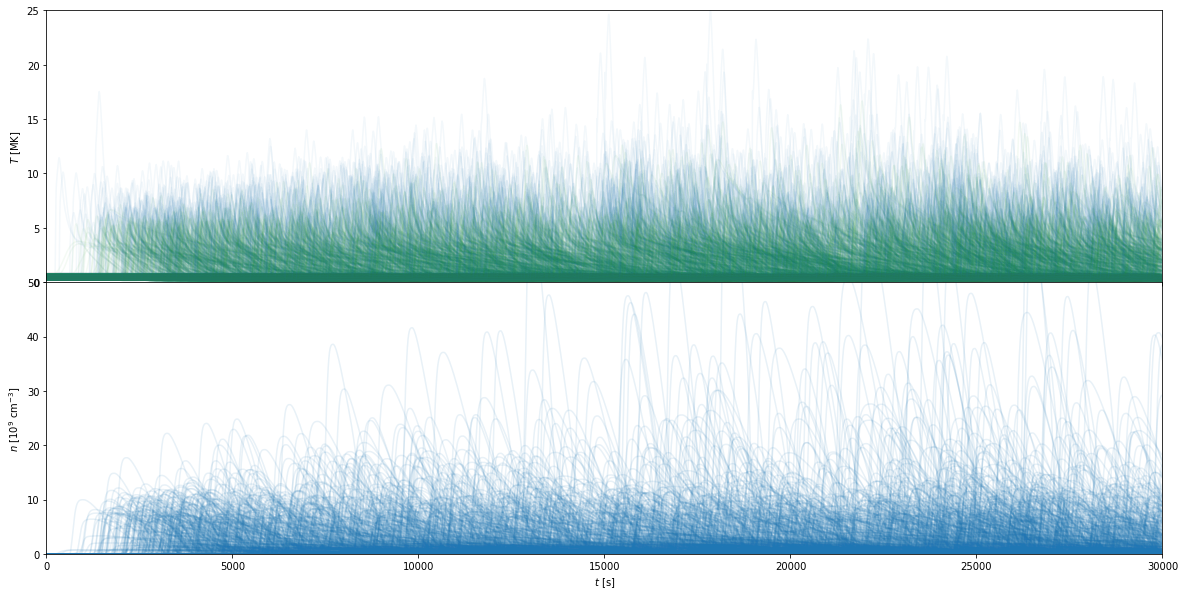

In [19]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in field.loops[::5]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.05)
    axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C2',alpha=0.05)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.1)
axes[0].set_xlim(0,base_config['total_time'])
axes[0].set_ylim(0,25)
axes[1].set_ylim(0,50)
axes[0].set_ylabel(r'$T$ [MK]');
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]');
axes[1].set_xlabel(r'$t$ [s]');

In [20]:
field.save('/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/field_checkpoint')